In [1]:
import queue
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

- `JID`: integer number representing the identifier of a job
- `TID`: an integer number between 0 and nj, representing the identifier of tasks belonging to job j
- `ta`: arrival time of task measured in milliseconds
- `C`: running time in seconds required to run the task on a Google Normalized Computing Unit (GNCU)
- `M`: amount of memory required to run the task, expressed in Google Normalized Memory Unit (GNMU)
- `N`: number of servers
- `X = C/µ`: service time of a task
- `1 GNMU`: amount of memory of a server
- `µ`: processing power expressed in `GNCU`

In [2]:
# Import data.
data = pd.read_csv('Cell_a.csv')

# Check if we import all the rows.
if data.shape[0] == 2329133:
    print('All rows correctly imported! \U0001f44d')

# Rename columns.
data = data.rename(columns={'Job_ID': 'JID',
                            'Task_ID': 'TID',
                            'Arrival_Time': 't_a',
                            'CPU': 'C',
                            'Memory': 'M'})
data.t_a = data.t_a / 1e6
data = data.sort_values('t_a', ignore_index=True)

data.head()

All rows correctly imported! 👍


,JID,TID,t_a,C,M
0,375000667413,0,603.026300,0.041851,0.001169
1,375000669289,0,606.413041,0.024968,0.001179
2,375000670586,0,608.994453,0.024176,0.001173
3,375000670588,0,608.994466,0.019552,0.001163
4,375000670590,0,609.042903,0.028044,0.001179


### Data exploration and visualization

In [3]:
pd.DataFrame(data.groupby('JID').count().TID)

,TID
JID,
375000667413,1
375000669289,1
375000670586,1
375000670588,1
375000670590,1
...,...
400465207745,1
400465219425,2
400465256347,1


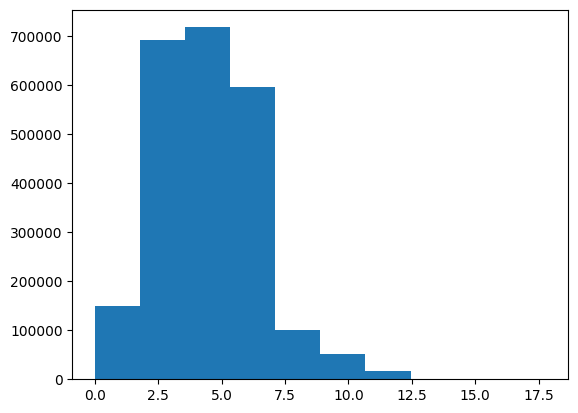

In [4]:
plt.hist(np.log(data.C+1));

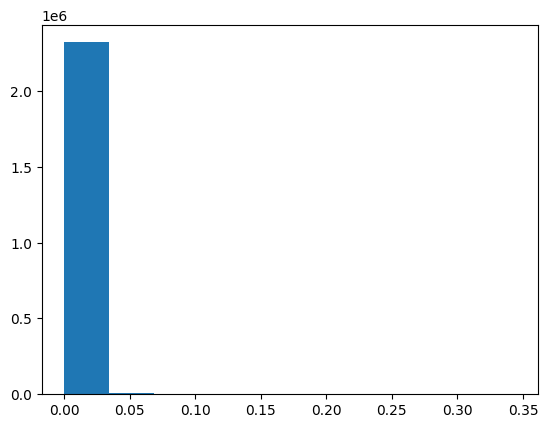

In [5]:
plt.hist(np.log(data.M+1));

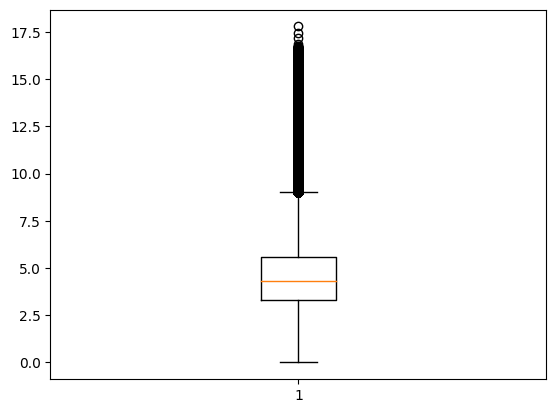

In [6]:
plt.boxplot(np.log(data.C+1));

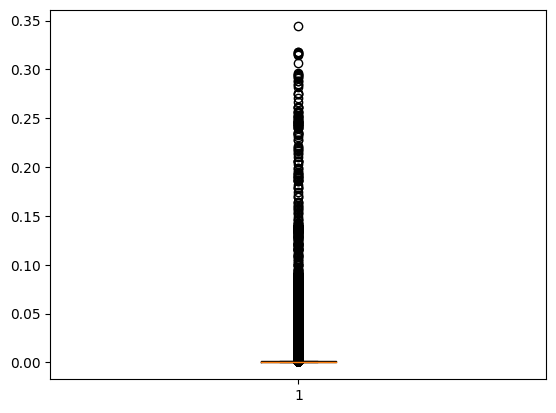

In [7]:
plt.boxplot(np.log(data.M+1));

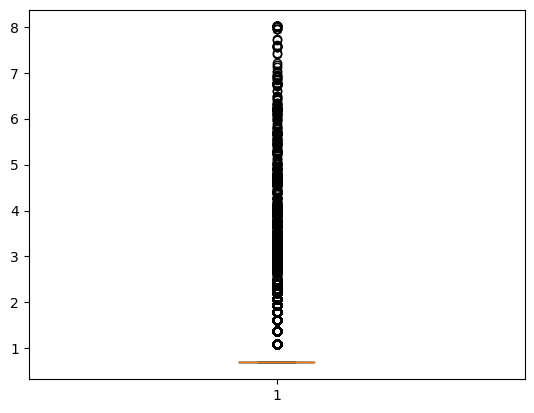

In [8]:
freq = pd.DataFrame(data.groupby('JID').count().TID)
plt.boxplot(np.log(freq+1));

In [9]:
print(data.M.describe())
print(data.C.describe())

count    2.329133e+06
mean     1.497997e-03
std      5.076826e-03
min      0.000000e+00
25%      5.397797e-04
50%      8.687973e-04
75%      1.123428e-03
max      4.106445e-01
Name: M, dtype: float64
count    2.329133e+06
mean     3.962583e+03
std      1.357256e+05
min      0.000000e+00
25%      2.649117e+01
50%      7.241821e+01
75%      2.701645e+02
max      5.278707e+07
Name: C, dtype: float64


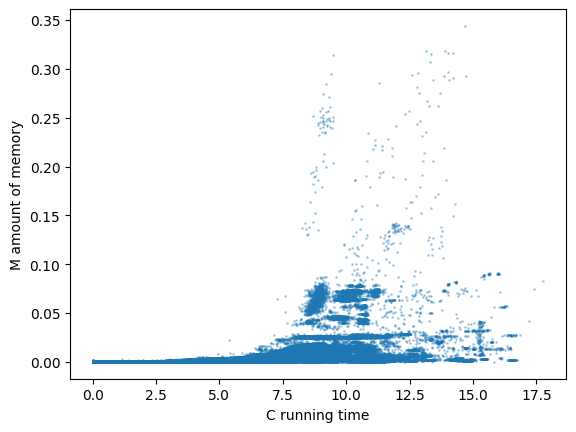

In [10]:
plt.scatter(np.log(data.C+1), np.log(data.M+1), s=1, alpha=0.3)
plt.xlabel('C running time')
plt.ylabel('M amount of memory');

In [11]:
plt.scatter(data.t_a, np.log(data.C+1), c=data.JID, s=1, alpha=0.3)
plt.xlabel('Arrival time')
plt.ylabel('C running time');

: 

: 

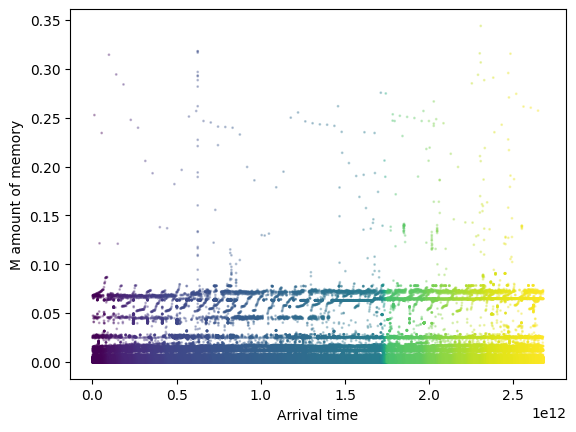

In [ ]:
plt.scatter(data.t_a, np.log(data.M+1), c=data.JID, s=1, alpha=0.3)
plt.xlabel('Arrival time')
plt.ylabel('M amount of memory');

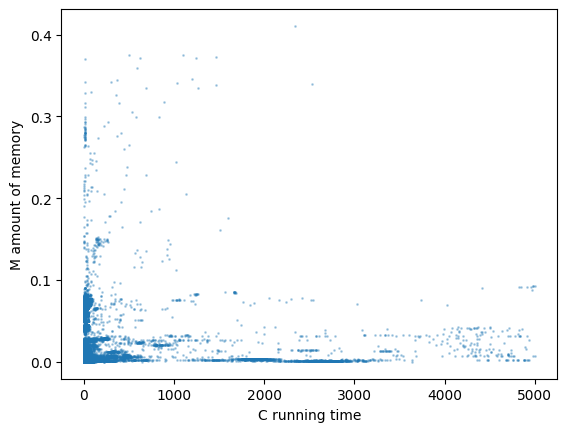

In [ ]:
plt.scatter(data.loc[data.C<5000].C, data.loc[data.C<5000].M, s=1, alpha=0.3)
plt.xlabel('C running time')
plt.ylabel('M amount of memory');

### Set parameters

In [3]:
N = 64
mu = 0.1

The purpose of the challenge is to define a dispatching
algorithm and scheduling algorithms, one for each server, so
as to get the best possible mean job response time.

### Baseline algorithms

- Dispatching: `LWL` 
- Scheduling: `FCFS` 

In [4]:
class Task:

    def __init__(self, job_id, task_id, ta, C, M):
        global mu

        self.jid = job_id
        self.tid = task_id
        self.ta = ta
        self.C = C
        self.M = M
        self.X = C / mu
        self.end_time = self.X

In [5]:
class Server:

    def __init__(self, server_id):
        self.server_id = server_id
        self.workload = 0
        self.time = 0
        self.utilization = 0
        self.n_messages = 0


    def compute_workload(self, task):
        delta_time = task.ta - self.time
        self.n_messages += 1

        # Check remainig workload after delta t.
        self.workload = max(self.workload - delta_time, 0)
        self.time = task.ta
        

    def assign_task(self, task):

        # Computing end time for the new task.
        task.end_time += self.workload
        
        # Add new task time to workload.
        self.workload += task.X
        self.utilization += task.X
        self.n_messages += 1

In [6]:
# How to decide to which servers assign the new task.
def LWL(task, servers):
    
    min_workload = float('inf')
    selected_server = None

    for server in servers.values():
        server.compute_workload(task)
        if server.workload < min_workload:
            min_workload = server.workload
            selected_server = server

    selected_server.assign_task(task)


# Simulation function.
def simulation(data, N):

    global servers
    global tasks

    # Creating servers objects.
    servers = {i+1: Server(i+1) for i in range(1, N+1)}

    # Creating tasks object.
    print('\u231B Creating task objects...')
    tasks = {}
    for index, row in tqdm(data.iterrows()):
        jid, tid, ta, C, M = row.values
        tasks[index] = Task(int(jid), int(tid), float(ta), float(C), float(M))
    print('\u2714\uFE0F Objects created!')

    # Execute dispatcher for each task.
    print("\n\u231B Running the 'simulation'...")
    for idx, task in tqdm(tasks.items()):
        LWL(task, servers) 
    print("\u2714\uFE0F 'Simulation' completed!")

"Simulation"

In [7]:
# data = data.head(100_000)

simulation(data, N)

⌛ Creating task objects...


2329133it [00:55, 41996.71it/s]


✔️ Objects created!

⌛ Running the 'simulation'...


100%|██████████| 2329133/2329133 [00:54<00:00, 42483.26it/s]

✔️ 'Simulation' completed!


#### Results

Tasks

In [8]:
rows = []
for key, obj in tasks.items():
    new_row = vars(tasks[key])
    row = {key: val for key, val in new_row.items()}
    rows.append(row)

df_tasks = pd.DataFrame(rows)
df_tasks['final_time'] = df_tasks['ta'] + df_tasks['end_time']
display(df_tasks)

,jid,tid,ta,C,M,X,end_time,final_time
0,375000667413,0,6.030263e+02,0.041851,0.001169,0.418510,0.418510,6.034448e+02
1,375000669289,0,6.064130e+02,0.024968,0.001179,0.249681,0.249681,6.066627e+02
2,375000670586,0,6.089945e+02,0.024176,0.001173,0.241756,0.241756,6.092362e+02
3,375000670588,0,6.089945e+02,0.019552,0.001163,0.195522,0.195522,6.091900e+02
4,375000670590,0,6.090429e+02,0.028044,0.001179,0.280437,0.280437,6.093233e+02
...,...,...,...,...,...,...,...,...
2329128,400465219425,1,2.678944e+06,0.000557,0.000004,0.005569,0.005569,2.678944e+06
2329129,400465219425,0,2.678944e+06,0.000343,0.000004,0.003433,0.003433,2.678944e+06
2329130,400465256347,0,2.678955e+06,0.002459,0.000050,0.024586,0.024586,2.678955e+06
2329131,400465256349,0,2.678955e+06,0.004349,0.000052,0.043488,0.043488,2.678955e+06


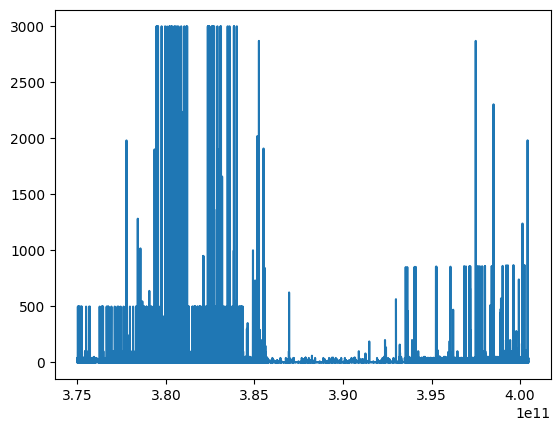

In [86]:
plt.plot(df_tasks.groupby('jid').count().M)
plt.xticks();

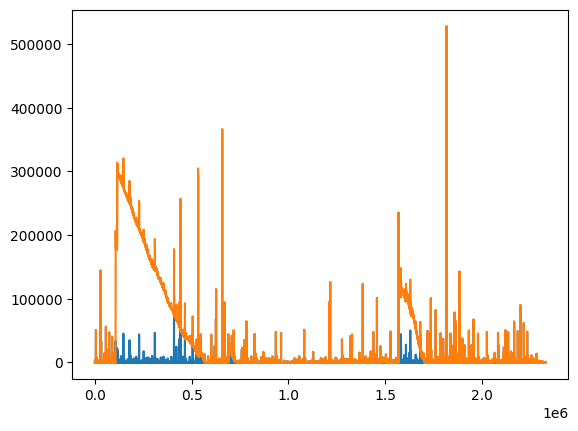

In [33]:
plt.plot(df_tasks.X)
plt.plot(df_tasks.end_time);

Stats on tasks

In [29]:
stats_df = df_tasks.groupby('jid').agg({'ta': 'min', 'final_time': 'max', 'X': 'sum'})
stats_df = stats_df.rename(columns={'ta': 'min_ta', 'final_time': 'max_ta_end_time', 'X': 'tot_job_X'})
stats_df['R'] = stats_df['max_ta_end_time'] - stats_df['min_ta']
stats_df = stats_df.reset_index()
stats_df['S'] = stats_df['R'] / stats_df['tot_job_X']
stats_df['S'] = stats_df['S'].replace(np.inf, 1)
stats_df['S'] = stats_df['S'].replace(np.nan, 1)
display(stats_df)

,jid,min_ta,max_ta_end_time,tot_job_X,R,S
0,375000667413,6.030263e+02,6.034448e+02,0.418510,0.418510,1.000000
1,375000669289,6.064130e+02,6.066627e+02,0.249681,0.249681,1.000000
2,375000670586,6.089945e+02,6.092362e+02,0.241756,0.241756,1.000000
3,375000670588,6.089945e+02,6.091900e+02,0.195522,0.195522,1.000000
4,375000670590,6.090429e+02,6.093233e+02,0.280437,0.280437,1.000000
...,...,...,...,...,...,...
1163056,400465207745,2.678935e+06,2.678936e+06,0.046768,0.046768,1.000000
1163057,400465219425,2.678944e+06,2.678944e+06,0.009003,0.005569,0.618644
1163058,400465256347,2.678955e+06,2.678955e+06,0.024586,0.024586,1.000000
1163059,400465256349,2.678955e+06,2.678955e+06,0.043488,0.043488,1.000000


Servers

In [10]:
rows = []
for key, obj in servers.items():
    new_row = vars(servers[key])
    row = {attributo: valore for attributo, valore in new_row.items()}
    rows.append(row)

df_servers = pd.DataFrame(rows)
display(df_servers)

,server_id,workload,time,utilization,n_messages
0,2,0.0,2.678969e+06,2.392070e+06,2429805
1,3,0.0,2.678969e+06,2.202912e+06,2441213
2,4,0.0,2.678969e+06,2.170160e+06,2421346
3,5,0.0,2.678969e+06,2.089002e+06,2420138
4,6,0.0,2.678969e+06,2.068521e+06,2398598
...,...,...,...,...,...
59,61,0.0,2.678969e+06,1.216859e+06,2352068
60,62,0.0,2.678969e+06,1.079479e+06,2352117
61,63,0.0,2.678969e+06,1.102943e+06,2356491
62,64,0.0,2.678969e+06,1.024594e+06,2355329


Summaries

In [69]:
R_avg = stats_df.R.mean()
S_avg = stats_df.S.mean()
tot_task_arrival = max(df_tasks['final_time']) - min(data.t_a)
rho_avg = (df_servers.utilization / tot_task_arrival).mean()
l_avg = df_servers.n_messages.mean()

summaries = {'Metric': ['Job responde time (R)', 'Job slowdown (S)', 'Utilization coefficient (rho)', 'Messaging load (L)'],
             'Baseline': [round(R_avg, 2), round(S_avg, 2), round(rho_avg, 3), round(l_avg, 2)]}

df_summaries = pd.DataFrame(summaries)

print('-' * 14)
print('Average values')
print('-' * 14)
display(df_summaries)

--------------
Average values
--------------


,Metric,Baseline
0,Job responde time (R),27591.850
1,Job slowdown (S),1231367.260
2,Utilization coefficient (rho),0.538
3,Messaging load (L),2365525.700


eCDDF

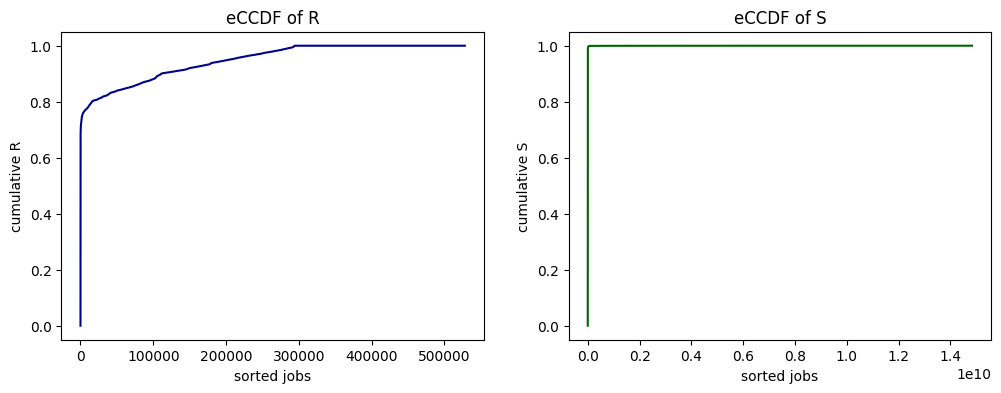

In [67]:
cols = ['darkblue', 'darkgreen']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sorted_data = np.sort(stats_df.R)
ccdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax[0].plot(sorted_data, ccdf, color = cols[0])
ax[0].set_title('eCCDF of R')
ax[0].set_ylabel('cumulative R')
ax[0].set_xlabel('sorted jobs')

sorted_data = np.sort(stats_df.S)
ccdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ax[1].plot(sorted_data, ccdf, color = cols[1])
ax[1].set_title('eCCDF of S')
ax[1].set_ylabel('cumulative S')
ax[1].set_xlabel('sorted jobs')

plt.show()

### Our algorithms

- Dispatching: `` 
- Scheduling: `SJF` 

In [101]:
class Task:

    def __init__(self, job_id, task_id, ta, C, M):
        global mu

        self.jid = job_id
        self.tid = task_id
        self.ta = ta
        self.C = C
        self.M = M
        self.X = C / mu
        self.end_time = self.X
    
    # To avoid comaprison problems among different Tasks.
    def __lt__(self, other):
        return self.ta < other.ta

In [102]:
class Server:

    def __init__(self, server_id):
        self.server_id = server_id
        self.workload = 0
        self.time = 0
        self.queue = queue.PriorityQueue()
        self.utilization = 0
        self.n_messages = 0


    def compute_workload(self, task):
        delta_time = task.ta - self.time
        self.n_messages += 1
        while not self.queue.empty:
            if delta_time > 0:
                next_task = self.queue.queue[0][1]
                if next_task.X <= delta_time:
                    running_task = self.queue.get()
                    delta_time -= running_task.X
                else:
                    next_task.X -= delta_time
                    break
            else:
                break

        self.time = task.ta
            

        # Check remainig workload after delta t.
        self.workload = max(self.workload - delta_time, 0)
        self.time = task.ta
        

    def assign_task(self, task):

        # Add task to queue.
        self.queue.put((task.X, task))

        # Update time of tasks behind this new task.
        for pos, el in enumerate(self.queue.queue[::-1]):
            if el.tid != task.tid:
                el.end_time += task.X
            else:
                p = pos 
                break

        # Compute end_time for the new task.
        task.end_time = sum([el.X for el in self.queue.queue[:pos]])
        
        # Add new task time to workload.
        self.workload += task.X
        self.utilization += task.X
        self.n_messages += 1

In [104]:
def simulation(data, N):

    global servers
    global tasks

    # Creating servers objects.
    servers = {i: Server(i) for i in range(N)}

    # Creating tasks object.
    tasks = {}
    for index, row in tqdm(data.iterrows()):
        jid, tid, ta, C, M = row.values
        tasks[index] = Task(int(jid), int(tid), int(ta), float(C), float(M))

    # Execute dispatcher for each task.
    for idx, task in tqdm(tasks.items()):
        LWL(task, servers) 

    # Complete the tasks remained in the servers.
    for server in tqdm(servers.values()):
        server.finish_queue()

2329133it [01:24, 27600.33it/s]
100%|██████████| 64/64 [00:00<?, ?it/s]


In [ ]:
# data = data.head(200_000)


simulation(data, N)

In [109]:
rows = []
for key, obj in tasks.items():
    new_row = vars(tasks[key])
    row = {key: val for key, val in new_row.items()}
    rows.append(row)

df_tasks = pd.DataFrame(rows)
df_tasks['final_time'] = df_tasks['ta'] + df_tasks['end_time']

stats_df = df_tasks.groupby('jid').agg({'ta': 'min', 'final_time': 'max', 'X': 'sum'})
stats_df = stats_df.rename(columns={'ta': 'min_ta', 'final_time': 'max_ta_end_time', 'X': 'tot_job_X'})
stats_df['R'] = stats_df['max_ta_end_time'] - stats_df['min_ta']
stats_df = stats_df.reset_index()
stats_df['S'] = stats_df['R'] / stats_df['tot_job_X']
stats_df['S'] = stats_df['S'].replace(np.inf, 1)
stats_df['S'] = stats_df['S'].replace(np.nan, 1)

rows = []
for key, obj in servers.items():
    new_row = vars(servers[key])
    row = {attributo: valore for attributo, valore in new_row.items()}
    rows.append(row)

df_servers = pd.DataFrame(rows)


R_avg = stats_df.R.mean()
S_avg = stats_df.S.mean()
tot_task_arrival = max(df_tasks['final_time']) - min(data.t_a)
rho_avg = (1 - (df_servers.inactive_time / tot_task_arrival)).mean()
# l_avg = df_servers.n_messages.mean()

summaries = {'Metric': ['Job responde time (R)', 'Job slowdown (S)', 'Utilization coefficient (rho)', 'Messaging load (L)'],
             'Our': [round(R_avg, 2), round(S_avg, 2), round(rho_avg, 3), 'todo']}

df_summaries = pd.DataFrame(summaries)

print('-' * 14)
print('Average values')
print('-' * 14)
display(df_summaries)

--------------
Average values
--------------


,Metric,Our
0,Job responde time (R),284746.03
1,Job slowdown (S),287605.35
2,Utilization coefficient (rho),1.0
3,Messaging load (L),todo


###  Performance evaluation

Values of $\bar{R}$, $\bar{S}$, $\rho$, $\bar{L}$

Where:

- $R$ (job response time) $\longrightarrow$ time elapsing since the arrival of the first arriving task of a job until all tasks belonging to that job have been fully served

- $S$ (job slowdown) $\longrightarrow$ ratio of response time of the job to the sum of service times of all tasks belonging to the job

- $\rho_k$ (utilization coefficient of server $k$) $\longrightarrow$ fraction of time that the server k is busy serving tasks

- $L$ (messaging load) $\longrightarrow$ number of messages exchanged between the dispatcher and servers for a given task dispatching

Table with values of $\rho_k$, with $k=1, ..., 64$

Plot of the empirical Complementary Cumulative Distribution Function (eCCDF) of $R$ and $S$.

Repeating the above performance evaluation for: 

- our algorithms

- baseline algorithms (for comparison purposes), namely, **LWL dispatching** and **FCFS scheduling** in all servers.